# 2019년 10월 이커머스 데이터 EDA

In [22]:
# pip install plotly==5.8.0

In [13]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from dateutil.parser import parse
import missingno as msno

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

In [2]:
# org_df = pd.read_csv("D:/cp2_dataset/2019-Oct.csv")
# df = org_df.copy()

In [10]:
# csv -> parquet 파일로 변환
# df.to_parquet("D:/cp2_dataset/df.parquet", engine="pyarrow", compression="gzip")

In [2]:
# parquet 파일 읽기
df = pd.read_parquet('D:/cp2_dataset/df.parquet', engine='pyarrow')

## event_time 컬럼 나누기

In [3]:
# event_time 컬럼 타입 str -> datetime64로 변경
df["event_time"] = pd.to_datetime(df["event_time"])

In [4]:
df["event_time"]

0          2019-10-01 00:00:00+00:00
1          2019-10-01 00:00:00+00:00
2          2019-10-01 00:00:01+00:00
3          2019-10-01 00:00:01+00:00
4          2019-10-01 00:00:04+00:00
                      ...           
42448759   2019-10-31 23:59:58+00:00
42448760   2019-10-31 23:59:58+00:00
42448761   2019-10-31 23:59:58+00:00
42448762   2019-10-31 23:59:59+00:00
42448763   2019-10-31 23:59:59+00:00
Name: event_time, Length: 42448764, dtype: datetime64[ns, UTC]

In [5]:
# event_time 열 timezone UTC -> Asia/Dubai로 변경 (GMT +4)
df["event_time"] = df["event_time"].apply(lambda x : x.tz_convert("Asia/Dubai"))

In [6]:
df["event_time"]

0          2019-10-01 04:00:00+04:00
1          2019-10-01 04:00:00+04:00
2          2019-10-01 04:00:01+04:00
3          2019-10-01 04:00:01+04:00
4          2019-10-01 04:00:04+04:00
                      ...           
42448759   2019-11-01 03:59:58+04:00
42448760   2019-11-01 03:59:58+04:00
42448761   2019-11-01 03:59:58+04:00
42448762   2019-11-01 03:59:59+04:00
42448763   2019-11-01 03:59:59+04:00
Name: event_time, Length: 42448764, dtype: datetime64[ns, Asia/Dubai]

In [7]:
# event_time 월, 일, 요일, 시 빼내기
df["month"] = df["event_time"].dt.month
df["day"] = df["event_time"].dt.day
df["day_name"] = df["event_time"].apply(lambda x : x.day_name())
df["hour"] = df["event_time"].dt.hour

In [8]:
df.shape

(42448764, 13)

In [9]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session', 'month',
       'day', 'day_name', 'hour'],
      dtype='object')

In [10]:
column_order = ['event_time', 'month', 'day', 'day_name', 'hour', 
                'event_type', 'product_id', 'category_id', 'category_code', 
                'brand', 'price', 'user_id', 'user_session']
df_mod = df[column_order]

In [11]:
df_mod.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,44600062,2103807459595387724,None,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,17200506,2053013559792632471,furniture.living_room.sofa,None,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 04:00:04+04:00,10,1,Tuesday,4,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


## parquet 파일 저장 후 작업 개시

In [13]:
# event_time 컬럼 변경한 것 parquet 파일로 저장
df_mod.to_parquet("D:/cp2_dataset/df.parquet", engine="pyarrow", compression="gzip")

In [6]:
mod = pd.read_parquet('D:/cp2_dataset/df.parquet', engine='pyarrow')

In [3]:
mod.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,44600062,2103807459595387724,None,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,17200506,2053013559792632471,furniture.living_room.sofa,None,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 04:00:04+04:00,10,1,Tuesday,4,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [4]:
mod["event_type"].value_counts(normalize=True)

view        0.960673
cart        0.021827
purchase    0.017500
Name: event_type, dtype: float64

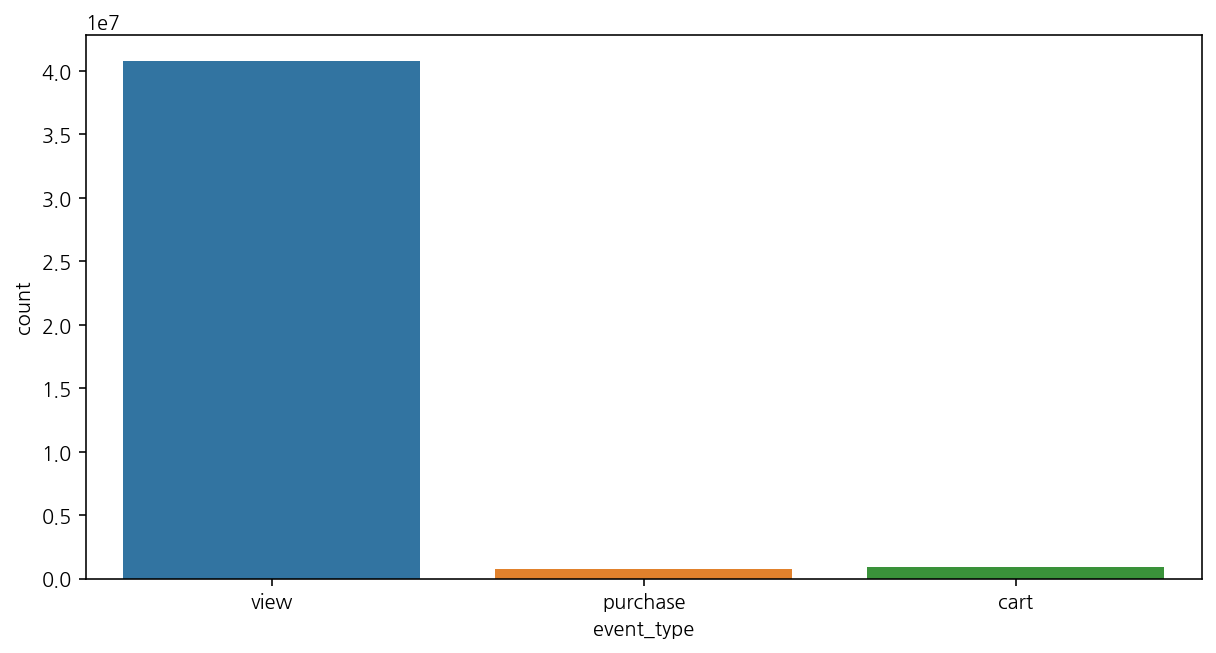

In [5]:
# event_type 분포
plt.figure(figsize=(10, 5))
cnt = sns.countplot(x=mod["event_type"])
plt.show()

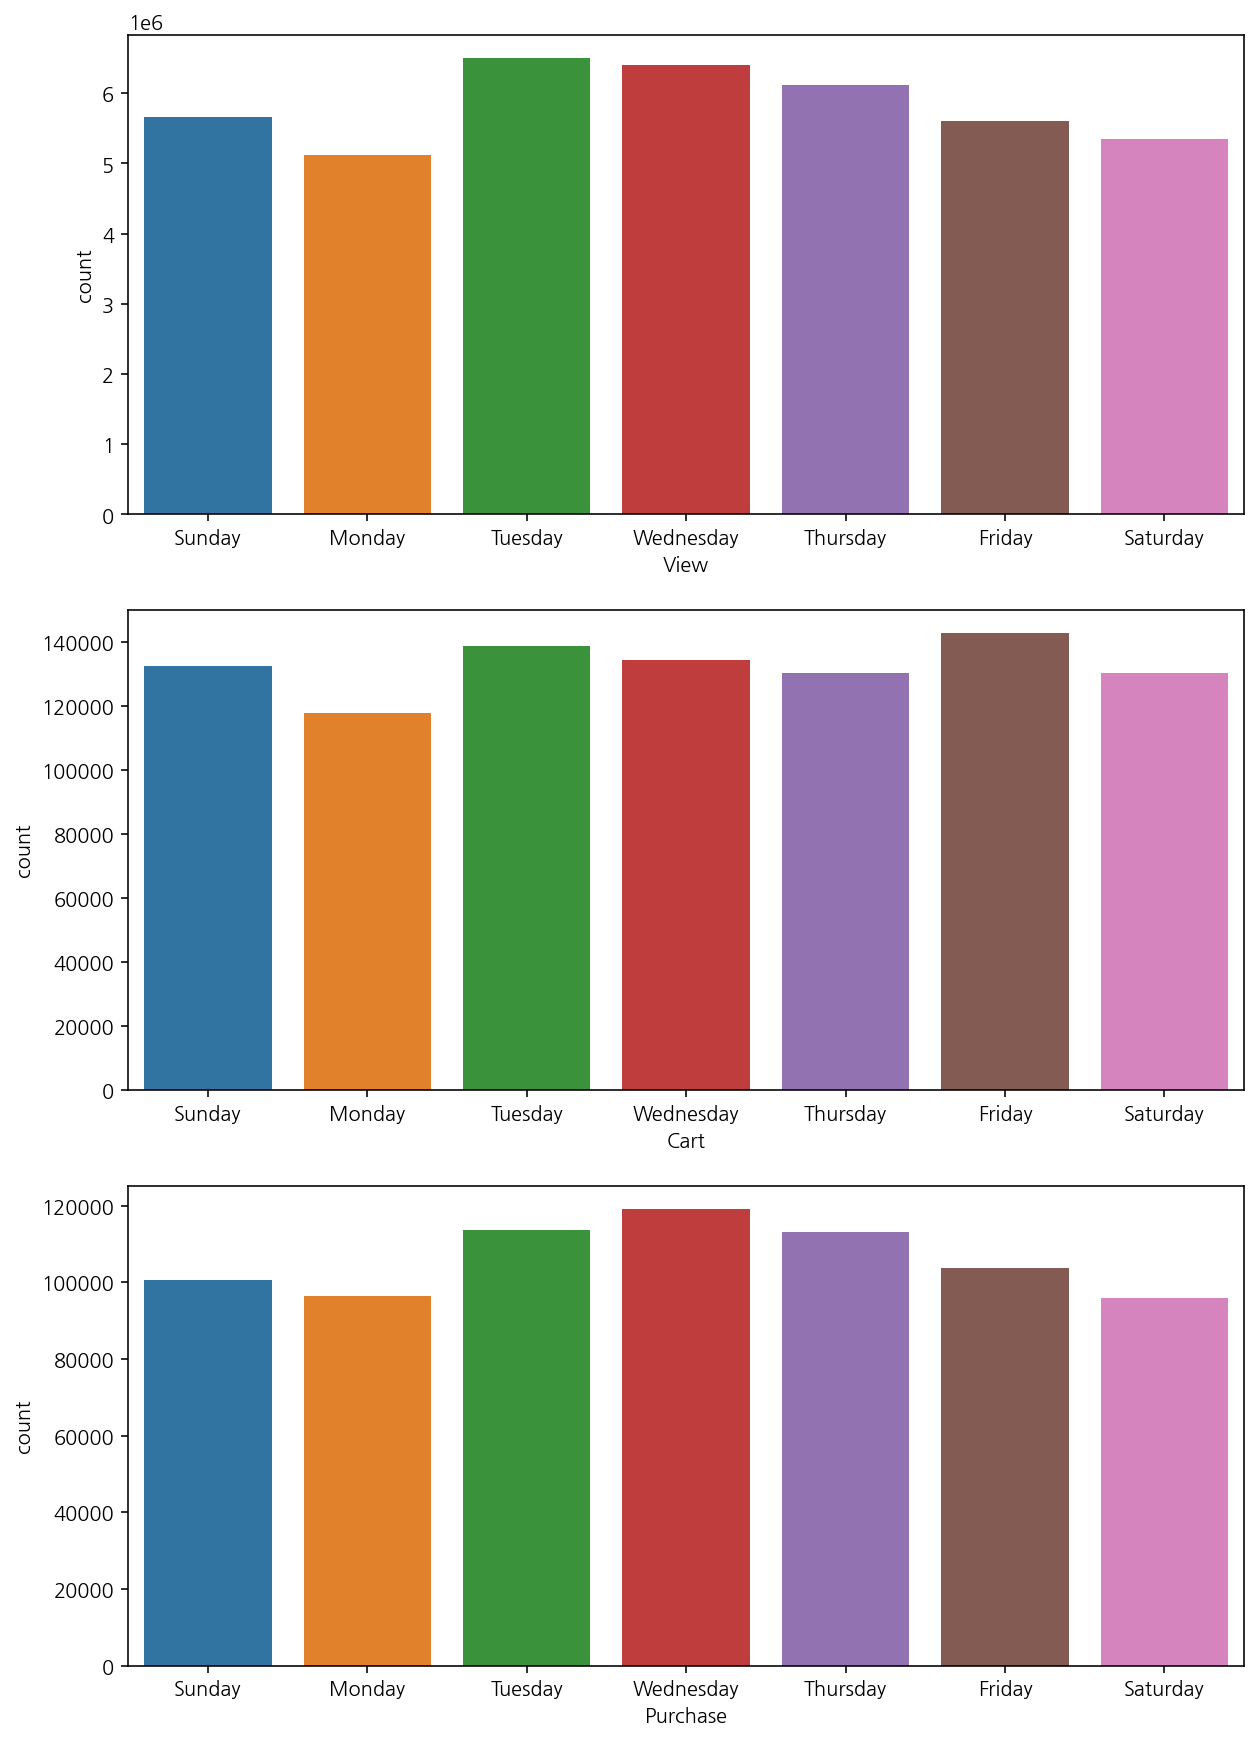

In [37]:
# 상품 클릭, 장바구니, 구매 조건 설정
view_cond = (mod["event_type"] == "view")
cart_cond = (mod["event_type"] == "cart")
purchase_cond = (mod["event_type"] == "purchase")

# 조건별로 countplot 생성
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# 요일별 상품 클릭한 숫자
view_cnt = sns.countplot(x=mod[view_cond]["day_name"],
                         order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],              ax=ax[0])
view_cnt.set_xlabel("View")

# 요일별 장바구니에 넣은 숫자
cart_cnt = sns.countplot(x=mod[cart_cond]["day_name"],
                         order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                         ax=ax[1])
cart_cnt.set_xlabel("Cart")

# 요일별 구매한 숫자
purchase_cnt = sns.countplot(x=mod[purchase_cond]["day_name"],
                             order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                             ax=ax[2])
purchase_cnt.set_xlabel("Purchase")

plt.show()

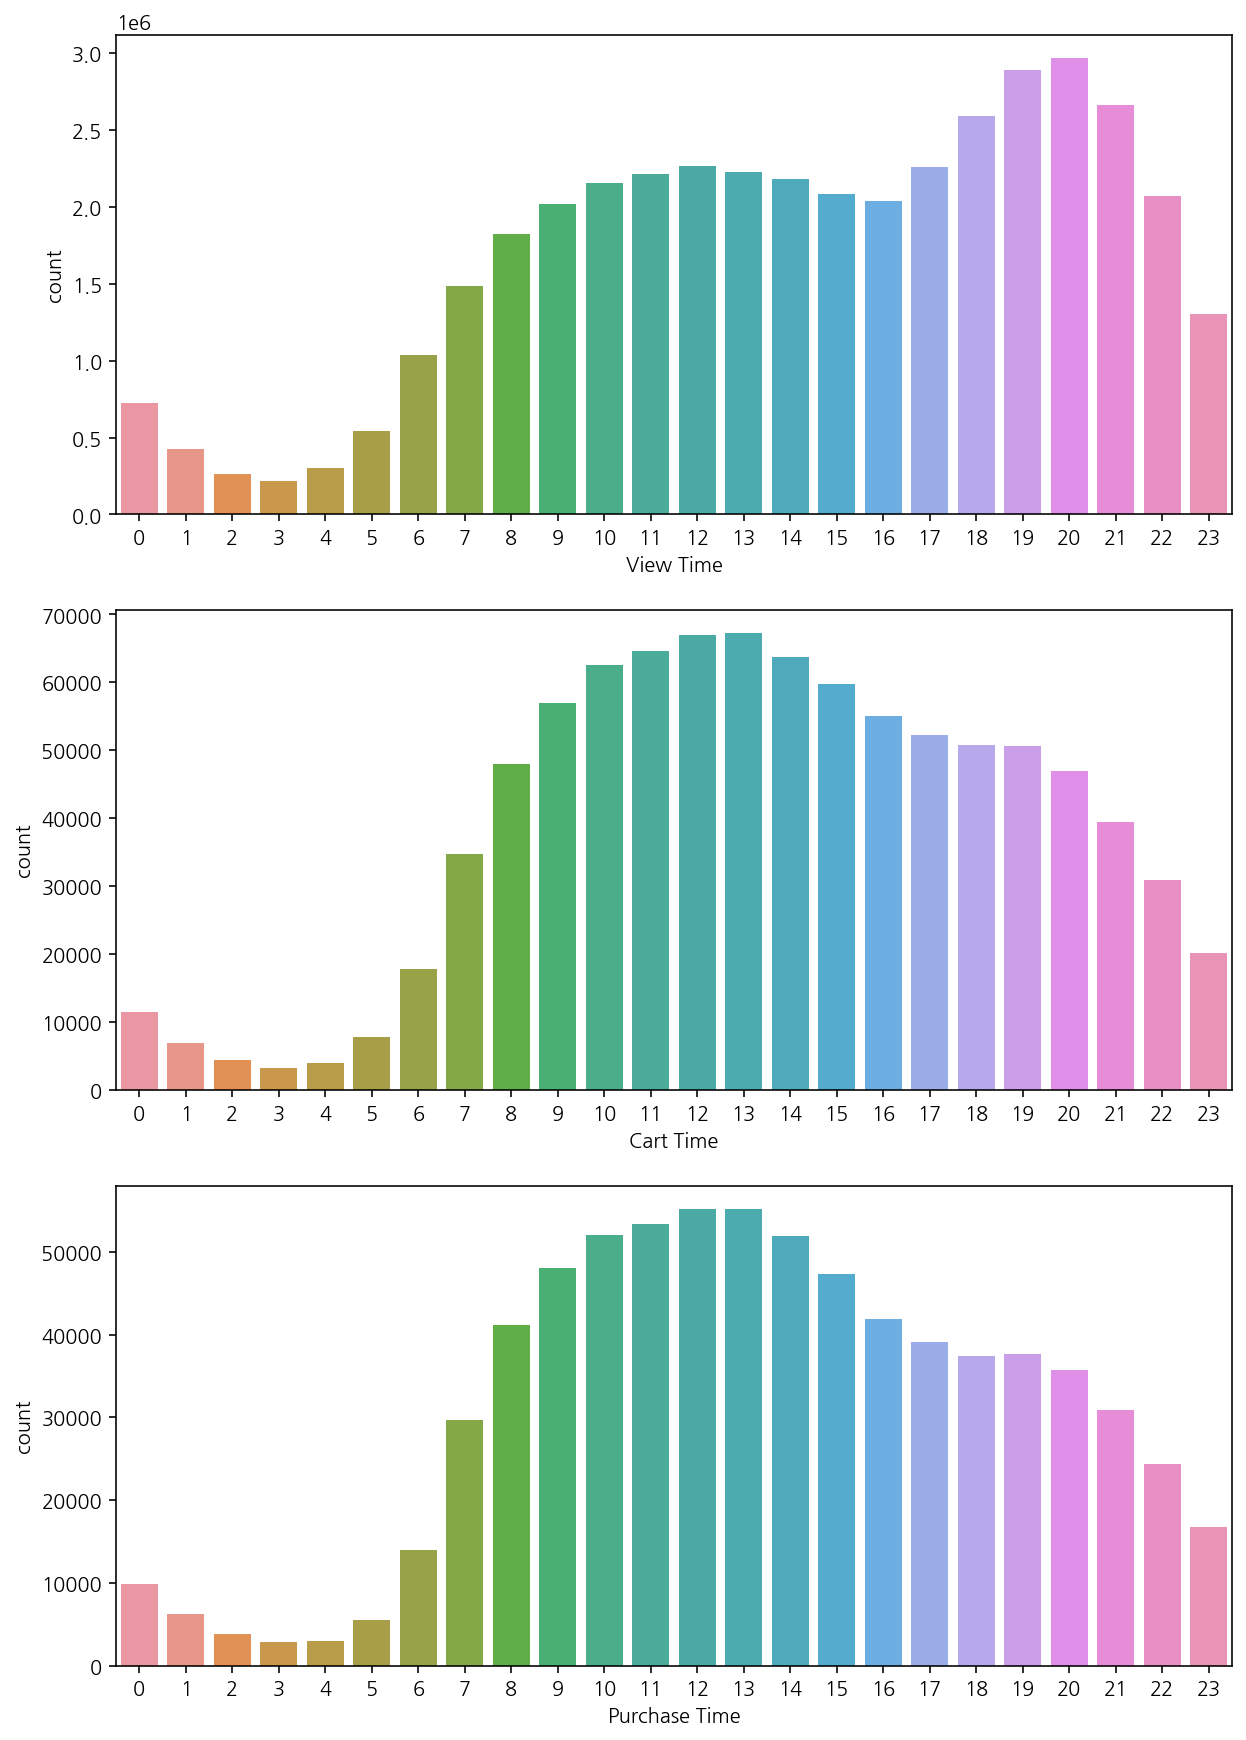

In [38]:
# 시간대별 View, Cart, Purchase

# 조건별로 countplot 생성
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# 요일별 상품 클릭한 숫자
view_time_cnt = sns.countplot(x=mod[view_cond]["hour"],
                              ax=ax[0])
view_time_cnt.set_xlabel("View Time")

# 요일별 장바구니에 넣은 숫자
cart_time_cnt = sns.countplot(x=mod[cart_cond]["hour"],
                         ax=ax[1])
cart_time_cnt.set_xlabel("Cart Time")

# 요일별 구매한 숫자
purchase_time_cnt = sns.countplot(x=mod[purchase_cond]["hour"],
                             ax=ax[2])
purchase_time_cnt.set_xlabel("Purchase Time")

plt.show()

## category_code TOP 10 분석

In [21]:
# 카테고리 코드 TOP 10
mod["category_code"].value_counts()[:10]

electronics.smartphone              11507231
electronics.clocks                   1311033
computers.notebook                   1137623
electronics.video.tv                 1113750
electronics.audio.headphone          1100188
appliances.kitchen.refrigerators      887755
appliances.kitchen.washer             869404
appliances.environment.vacuum         801670
apparel.shoes                         763901
auto.accessories.player               470208
Name: category_code, dtype: int64

In [7]:
# 대분류 TOP 10
main_cat = mod["category_code"].str.split(".").str[0].value_counts()[:10]
main_cat

electronics     16135623
appliances       4967294
computers        2324217
apparel          1542924
furniture        1247160
auto             1013115
construction      730834
kids              520619
accessories       238238
sport             176616
Name: category_code, dtype: int64

In [8]:
# 중분류 TOP 10
sub_cat_1st = mod["category_code"].str.split(".").str[1].value_counts()[:10]
sub_cat_1st

smartphone     11507231
kitchen         3531445
audio           1574674
clocks          1311033
shoes           1208383
environment     1147634
notebook        1137623
video           1126904
accessories     1013115
tools            719816
Name: category_code, dtype: int64

In [9]:
# 소분류 TOP 10
sub_cat_2nd = mod["category_code"].str.split(".").str[2].value_counts()[:10]
sub_cat_2nd

tv               1113750
headphone        1100188
refrigerators     887755
washer            869404
vacuum            801670
player            470208
keds              410304
bed               358453
subwoofer         313664
cabinet           301410
Name: category_code, dtype: int64

In [77]:
# 브랜드 TOP 10
brand_top10 = mod["brand"].value_counts()[:10]
brand_top10

samsung    5282775
apple      4122554
xiaomi     3083763
huawei     1111205
lucente     655861
lg          562404
bosch       557090
oppo        482887
sony        456644
acer        428153
Name: brand, dtype: int64

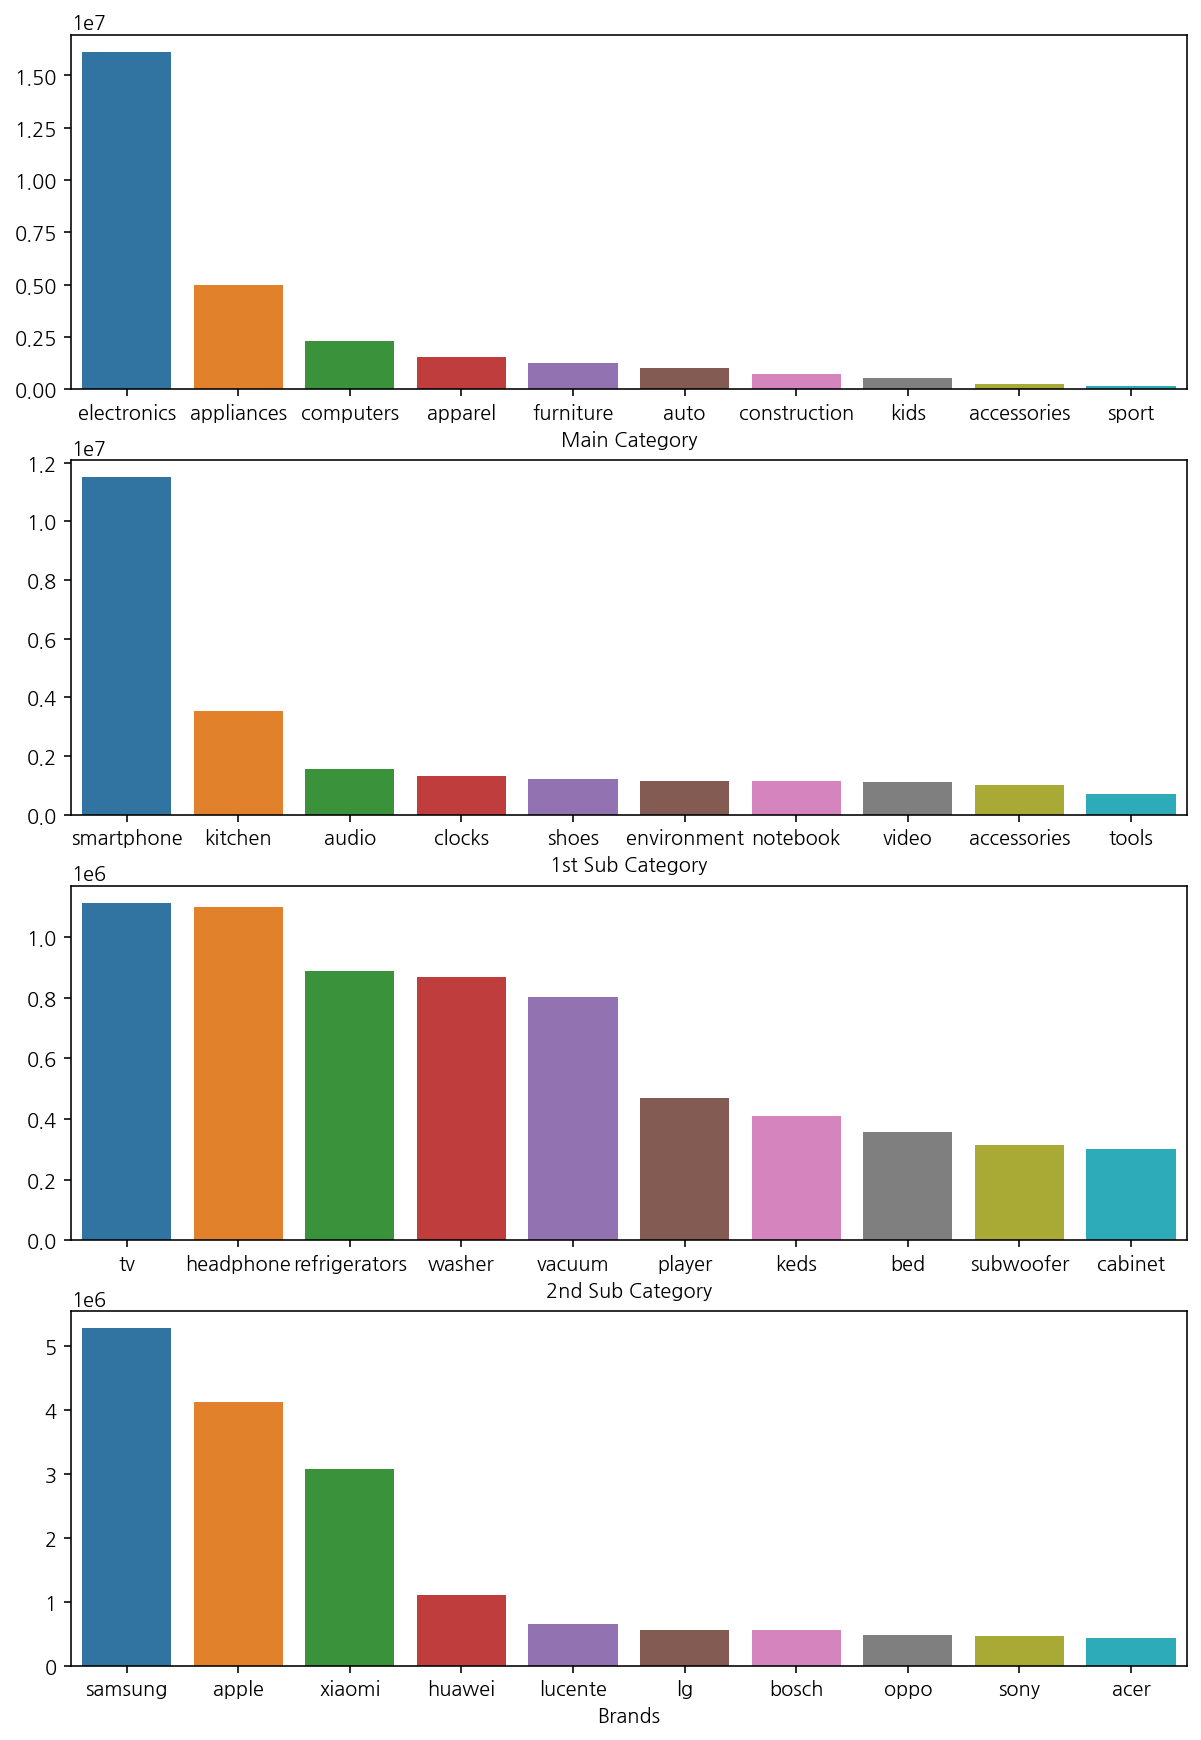

In [81]:
# 카테고리별 TOP 10 (대분류, 중분류, 소분류), 브랜드 TOP 10

# 조건별로 plot 생성
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))

# 메인 카테고리 (대분류) Top 10
main_bar = sns.barplot(x=main_cat.index, 
                       y=main_cat.values,
                       ax=ax[0])
main_bar.set_xlabel("Main Category")

# 중분류 Top 10
sub_1st_bar = sns.barplot(x=sub_cat_1st.index,
                          y=sub_cat_1st.values,
                          ax=ax[1])
sub_1st_bar.set_xlabel("1st Sub Category")

# 소분류 Top 10
sub_2nd_bar = sns.barplot(x=sub_cat_2nd.index,
                          y=sub_cat_2nd.values,
                          ax=ax[2])
sub_2nd_bar.set_xlabel("2nd Sub Category")

# 브랜드 Top 10
brand_bar = sns.barplot(x=brand_top10.index,
                        y=brand_top10.values,
                        ax=ax[3])
brand_bar.set_xlabel("Brands")

plt.show()

## 구매 히트맵

### 

## 결측치 확인 및 처리

In [3]:
mod.shape

(42448764, 13)

### 결측치 비율 시각화

In [47]:
# 결측치 percent 구함
null_total = mod.isnull().sum()
null_count = mod.isnull().count()
percent = round((null_total / null_count) * 100, 1)

# 결측치 개수, 퍼센트 데이터프레임으로 생성
missing_data = pd.concat([null_total, percent], axis=1, keys=["Total", "Percent"])

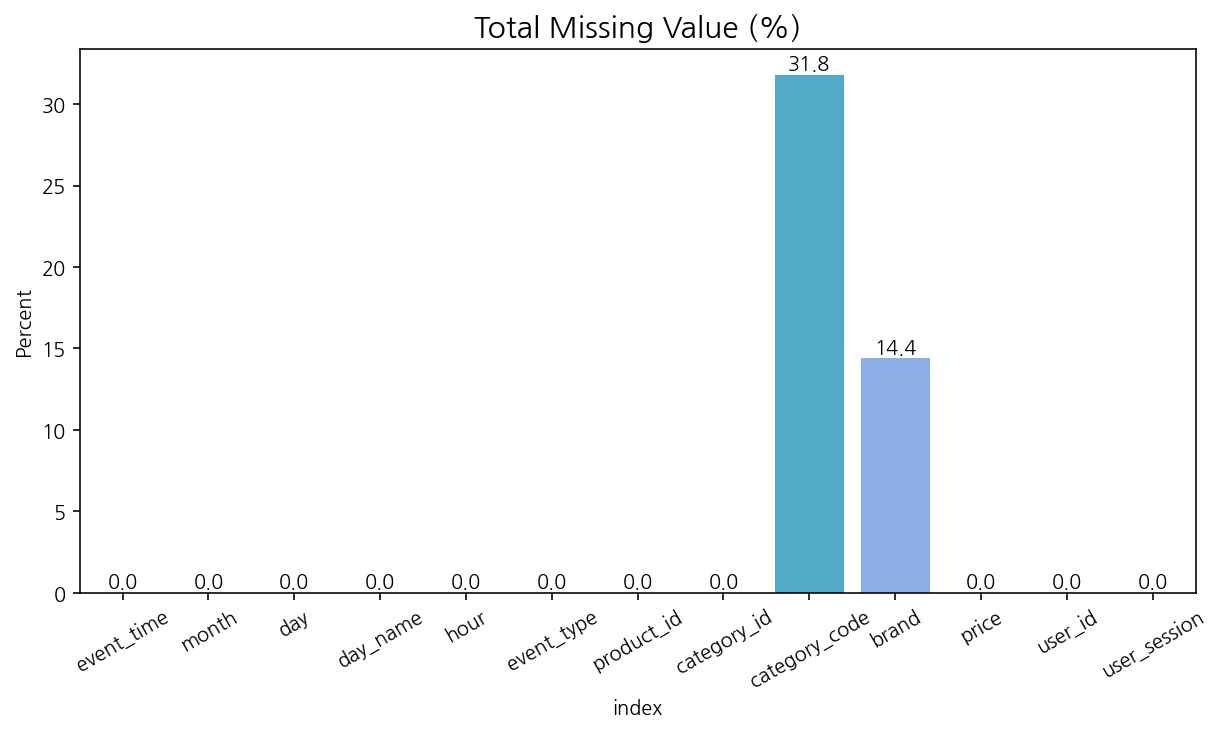

In [57]:
# 결측치 퍼센트 그래프 생성
plt.figure(figsize=(10, 5))
sns_pct = sns.barplot(x="index", y="Percent", data=missing_data.reset_index())
sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=30)

# bar 그래프 상단에 퍼센트 표기
for bar in sns_pct.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.3, "%.1f" % height, ha="center")

sns_pct.set_title("Total Missing Value (%)", fontsize=15)
plt.show()

### 결측치 상관관계 확인

#### 걸측치 종류

- 완전 무작위 결측 (MCAR : Missing Completely At Random)

    - 변수 상에서 발생한 결측치가 다른 변수들과 아무런 상관이 없는 경우 완전 무작위 결측이라고 부른다.<br>
    대부분의 결측치 처리 패키지가 MCAR을 가정으로 하고 있고 보통 우리가 생각하는 결측치라고 생각하면 된다.   
    예를 들어, 데이터를 깜박하고 입력 안하거나 전산오류로 누락된 경우이다.   
    이러한 결측치는 보통 제거하거나 데이터 셋에서 단순 무작위 표본추출을 통해 완벽한 데이터셋으로 만들 수 있다.

- 무작위 결측 (MAR : Missing At Random)

    - 결측값이 결측된 변수와는 관련이 없지만 다른변수와는 관련이 있는 경우 무작위 결측이라고 부른다.  
    예를 들어, 여성이 남성보다 체중을 기입하지 않는다. 라고 하면 체중에 결측값이 생기지만,  
    이는 체중 변수와 관련이 있는 것이 아닌 성별 변수와 관련이 있다. 

- 비 무작위 결측 (MNAR : Missing Not At Random)

    - 위 두가지 유형이 아닌 경우 MNAR이라고 하고, 결측값이 결측된 변수와 관련이 있는 경우 비 무작위 결측이라고 한다.  
    예를 들어, 서비스에 불만족한 고객들은 만족도 설문에 응답하지 않는다.  
    
    - 링크 : https://syj9700.tistory.com/10

- 구분 예시

    * 비 무작위 결측 (MNAR)  

        + 우울증이 너무 심한 응답자들이 우울증 문항에 허위 기술을 하거나,  
        정치적, 종교적인 이유로 실제와 전혀 다른 응답하는 경우  
        
        + 위의 예시처럼 설문지 응답에서 중요한 특정 집단이 의도적으로 자신을 감춰버린 상태
    
    * 3번 상태 (NMAR)가 아니라면, 이 결측값 발생이 어느정도 독립적으로 발생하지 않았을까? 라고 생각 가능한 상태가 되고,
    이는 완벽하게 우연히 발생했다면 1번 완전 무작위 결측이 된다 (MCAR)

    * 즉, 결측값의 발생에 뚜렷한 어떤 인과 관계가 숨어있는지 여부로 구분지으면 된다  

    * 링크 : https://gooopy.tistory.com/43  

    * MCAR(Missing Completely At Random)
        
        + 특정 column(c_k)의 결측 여부가 완전히 random으로 발생하는 경우,  

        + 즉 c_k가 다른 c_1, c_2, ...와는 관련이 없을 때를 가리킴

    * MAR(Missing At Random)  

        + 특정 c_k의 결측 여부가 다른 c_1, c_2, ... 중 몇몇과 관련이 있는 경우  

        + 예를 들면, 소득수준(=c_1)에 따라 학업성취도(=c_k)의 결측 여부가 관련이 있을 경우

    * MNAR(Missing Not At Random, non ignorable)  

        + 특정 c_k의 결측 여부가 c_k의 값과 관련이 있는 경우  
        
        + 예를 들면, 학업성취도가 낮은 학생들이 학업성취도에 응답하지 않는 경우

Text(0.5, 1.0, 'Correlation with Missing Values')

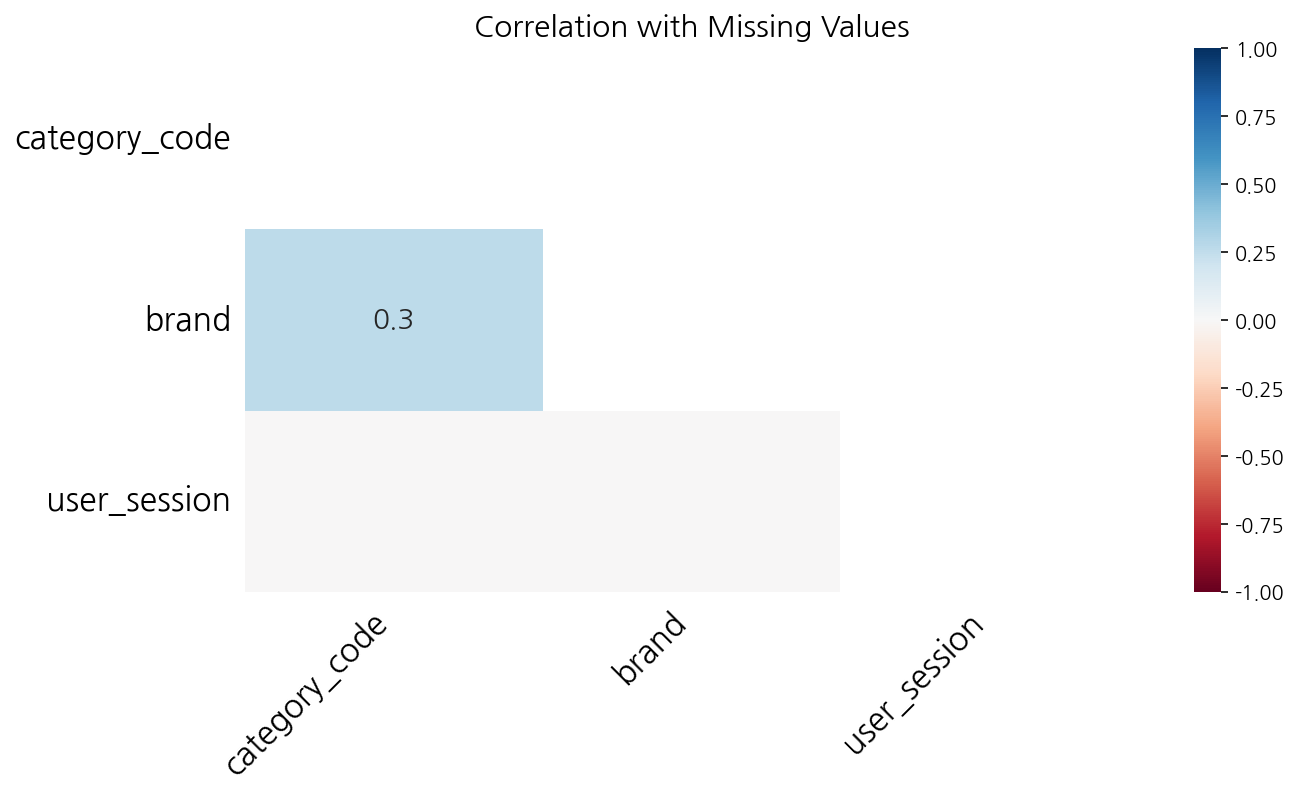

In [4]:
missingdata_col = mod.columns[mod.isnull().any()].tolist()
msno.heatmap(mod[missingdata_col], figsize=(10, 5))
# msno.heatmap(mod, figsize=(10, 5))
plt.title("Correlation with Missing Values", fontsize=15)

# category_code, brand 상관관계 0.3
# category_code에 결측치가 있으면, brand에 결측치가 존재할 가능성이 어느정도 있다
# -> category_code는 MCAR, brand는 MAR 결측치이다

### 결측치 제거

#### category_code, brand 동시에 결측된 값 제거

In [14]:
# 전체 값 대비 category_code, brand 전부 결측인 값들의 비율
null_cond = (mod["category_code"].isna()) & (mod["brand"].isna())
(mod[null_cond].shape[0] / mod.shape[0]) * 100

8.821333407964483

In [15]:
# 전체 데이터에서 category_code, brand 둘다 NaN 값인 경우 제거
both_null_cond = (mod["category_code"].notna()) | (mod["brand"].notna())
mod[both_null_cond].shape

(38704217, 13)

In [16]:
no_both_null = mod[both_null_cond]
no_both_null.shape

(38704217, 13)

In [17]:
# 결측치 percent 구함
null_total_2 = no_both_null.isnull().sum()
null_count_2 = no_both_null.isnull().count()
percent_2 = round((null_total_2 / null_count_2) * 100, 1)

# 결측치 개수, 퍼센트 데이터프레임으로 생성
missing_data_2 = pd.concat([null_total_2, percent_2], axis=1, keys=["Total", "Percent"])

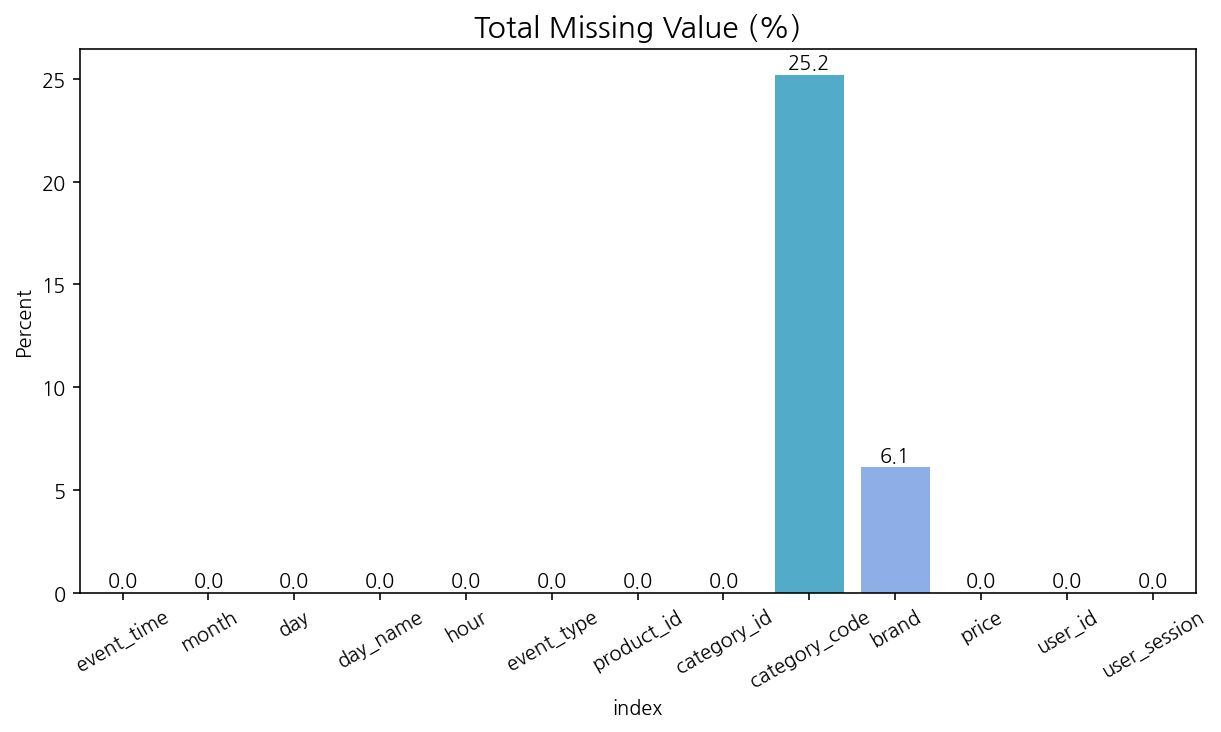

In [18]:
# 결측치 퍼센트 그래프 생성
plt.figure(figsize=(10, 5))
sns_pct_2 = sns.barplot(x="index", y="Percent", data=missing_data_2.reset_index())
sns_pct_2.set_xticklabels(sns_pct_2.get_xticklabels(), rotation=30)

# bar 그래프 상단에 퍼센트 표기
for bar in sns_pct_2.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.3, "%.1f" % height, ha="center")

sns_pct_2.set_title("Total Missing Value (%)", fontsize=15)
plt.show()

#### 연속형 변수 상관관계

##### 상관관계 테이블 생성 (연속형 변수)

C:\Users\aryij\AppData\Local\Temp\ipykernel_23676\4131002810.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


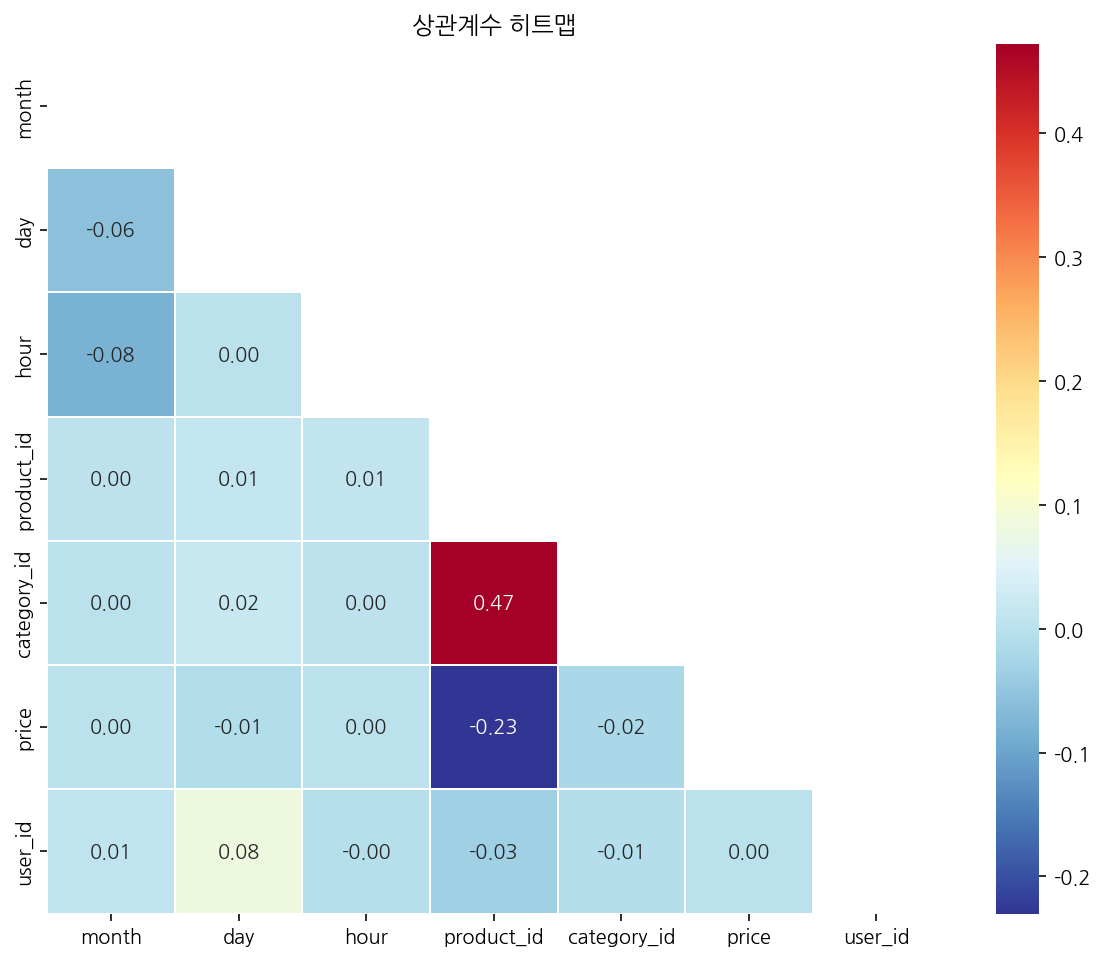

In [19]:
# 상관계수 테이블
corr = no_both_null.corr()

# 히트맵 사이즈 설정
plt.figure(figsize=(10, 8))

# 히트맵 형태 정의. 여기서는 삼각형 형태 (위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵 그리기
sns.heatmap(data=corr,          # corr = 상관계수 테이블
            annot=True,         # 히트맵에 값 표시
            mask=mask,          # 히트맵 형태, 여기서는 위에서 정의한 삼각형 형태
            fmt=".2f",          # 값 표시 방식. 소수점 2번째 자리까지
            linewidths=1.,      # 경계면 실선 구분 여부
            cmap="RdYlBu_r")    # 사용할 색 지정 (python colormap 검색)
plt.title("상관계수 히트맵")
plt.show()

# product_id, category_id 상관관계 0.47

In [20]:
null_cond_2 = (no_both_null["brand"].isna())
no_both_null[null_cond_2].shape

(2372533, 13)

In [21]:
no_both_null

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,44600062,2103807459595387724,None,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,17200506,2053013559792632471,furniture.living_room.sofa,None,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 04:00:04+04:00,10,1,Tuesday,4,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42448759,2019-11-01 03:59:58+04:00,11,1,Friday,3,view,2300275,2053013560530830019,electronics.camera.video,gopro,527.40,537931532,22c57267-da98-4f28-9a9c-18bb5b385193
42448760,2019-11-01 03:59:58+04:00,11,1,Friday,3,view,10800172,2053013554994348409,None,redmond,61.75,527322328,5054190a-46cb-4211-a8f1-16fc1a060ed8
42448761,2019-11-01 03:59:58+04:00,11,1,Friday,3,view,5701038,2053013553970938175,auto.accessories.player,kenwood,128.70,566280422,05b6c62b-992f-4e8e-91f7-961bcb4719cd
42448762,2019-11-01 03:59:59+04:00,11,1,Friday,3,view,21407424,2053013561579406073,electronics.clocks,tissot,689.85,513118352,4c14bf2a-2820-4504-929d-046356a5a204


In [13]:
# 전체 값 대비 brand가 lucente인 것의 비율
lucente_cond = (mod["brand"] == "lucente")
(mod[lucente_cond].shape[0] / mod.shape[0]) * 100

1.5450650106090251

In [ ]:
# category_code, brand 둘 중 하나라도 결측치가 있는 데이터
cond = (mod["category_code"].isna()) | (mod["brand"].isna())
mod[cond]["brand"].value_counts().head(20)

lucente     655861
xiaomi      386119
cordiant    368277
sony        235406
stels       231895
bosch       227255
triangle    212952
nokian      185123
force       166369
redmond     153856
samsung     123872
philips     115976
yokohama    115014
dauscher    113601
omabelle    111826
artel       100935
skad         98592
sokolov      98409
vitek        97454
polaris      94692
Name: brand, dtype: int64

In [ ]:
lucente = (mod["brand"] == "lucente")
# mod[lucente]["category_code"].value_counts()
mod[lucente]["price"].value_counts().sort_index(ascending=False)

887.28     262
845.84      18
832.20    3202
784.58      16
782.00    6864
          ... 
11.33       29
10.81      347
10.30      122
10.04       30
9.52        28
Name: price, Length: 672, dtype: int64

In [ ]:
mod[lucente]

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
53,2019-10-01 04:00:42+04:00,10,1,Tuesday,4,view,26400291,2053013563651392361,None,lucente,188.94,551331813,19ded3e3-823b-4f51-ad00-ab84f364f5ef
58,2019-10-01 04:00:44+04:00,10,1,Tuesday,4,view,26500313,2053013563550729061,None,lucente,267.19,525856698,f72ea16b-4ec3-44f8-8fcd-35d89984b744
85,2019-10-01 04:01:12+04:00,10,1,Tuesday,4,view,26500144,2053013563550729061,None,lucente,259.21,525856698,f72ea16b-4ec3-44f8-8fcd-35d89984b744
150,2019-10-01 04:02:05+04:00,10,1,Tuesday,4,view,26201000,2053013563693335403,None,lucente,106.31,555447748,b50d1ae8-1948-4517-8460-09b7601ceef6
264,2019-10-01 04:03:46+04:00,10,1,Tuesday,4,view,26300089,2053013563584283495,None,lucente,271.82,552985520,7e776b9d-4f32-494f-9fbe-f293046cdd6c
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42447923,2019-11-01 03:53:37+04:00,11,1,Friday,3,view,26300188,2053013563584283495,None,lucente,709.67,497681858,900fe3e7-a6b3-49f6-9a9c-a8847822f75a
42448006,2019-11-01 03:54:15+04:00,11,1,Friday,3,view,26404396,2053013563651392361,None,lucente,58.43,564353057,b916c35a-600b-4d21-ad90-5b196a3811b1
42448291,2019-11-01 03:56:11+04:00,11,1,Friday,3,view,26400291,2053013563651392361,None,lucente,200.26,565098257,dfbfd3f3-9347-45a1-b572-ec3897d327dc
42448464,2019-11-01 03:57:44+04:00,11,1,Friday,3,view,26400686,2053013563651392361,None,lucente,406.45,533351761,6229f7bc-7440-44dc-8768-d924071fb879


In [ ]:
xiao = (mod["brand"] == "xiaomi")
xiao_none = (mod["brand"] == "xiaomi") & (mod["category_code"].isna())
mod[xiao_none]["price"].value_counts().head(30)

28.42     20833
27.61     16326
29.09     13886
28.55      9327
28.80      8980
28.73      8879
28.56      8761
28.95      8451
28.31      7359
48.14      6027
29.01      5758
29.54      5311
28.28      5088
102.70     4280
29.56      4146
21.85      3929
21.09      3725
81.86      3578
78.51      3356
76.94      3327
28.69      3207
20.34      3113
28.36      3078
28.30      3026
22.96      3000
22.88      2981
28.44      2905
29.51      2885
29.58      2842
29.08      2839
Name: price, dtype: int64

In [ ]:
xiao_20 = (mod["brand"] == "xiaomi") & (mod["price"] >= 20) & (mod["price"] < 30)
mod[xiao_20]["category_code"].value_counts()

electronics.audio.headphone     125972
appliances.personal.scales        4330
appliances.kitchen.kettle          840
accessories.umbrella               806
accessories.bag                    782
computers.peripherals.mouse        420
construction.tools.light           410
furniture.bedroom.pillow           138
construction.tools.generator        22
stationery.cartrige                  1
Name: category_code, dtype: int64

In [ ]:
xiao_75 = (mod["brand"] == "xiaomi") & (mod["price"] >= 75) & (mod["price"] < 80)
mod[xiao_75]["category_code"].value_counts()

electronics.audio.headphone    4161
electronics.smartphone         1864
electronics.clocks              802
auto.accessories.compressor     365
Name: category_code, dtype: int64

In [ ]:
xiao_70 = (mod["brand"] == "xiaomi") & (mod["price"] >= 70) & (mod["price"] < 75)
mod[xiao_70]["category_code"].value_counts()

electronics.audio.headphone       16405
electronics.clocks                15853
auto.accessories.videoregister    13948
electronics.smartphone            10829
Name: category_code, dtype: int64

In [ ]:
mod[xiao_70]["price"].sort_values(ascending=False)

35043457    74.97
35188585    74.97
35131829    74.97
35131321    74.97
35125458    74.97
            ...  
37973194    70.13
38295010    70.13
38297264    70.13
38297528    70.13
38109054    70.13
Name: price, Length: 59850, dtype: float64

In [15]:
# event_time 월만 빼내기
df["event_time"].dt.month

0           10
1           10
2           10
3           10
4           10
            ..
42448759    11
42448760    11
42448761    11
42448762    11
42448763    11
Name: event_time, Length: 42448764, dtype: int64

In [16]:
# event_time 일만 빼내기
df["event_time"].dt.day

0           1
1           1
2           1
3           1
4           1
           ..
42448759    1
42448760    1
42448761    1
42448762    1
42448763    1
Name: event_time, Length: 42448764, dtype: int64

In [17]:
# event_time 시간만 빼내기
df["event_time"].dt.hour

0           4
1           4
2           4
3           4
4           4
           ..
42448759    3
42448760    3
42448761    3
42448762    3
42448763    3
Name: event_time, Length: 42448764, dtype: int64

In [18]:
# event_time 분만 빼내기
df["event_time"].dt.minute

0            0
1            0
2            0
3            0
4            0
            ..
42448759    59
42448760    59
42448761    59
42448762    59
42448763    59
Name: event_time, Length: 42448764, dtype: int64

In [19]:
# event_time 요일 이름만 빼내기
df["event_time"].apply(lambda x : x.day_name())

0           Tuesday
1           Tuesday
2           Tuesday
3           Tuesday
4           Tuesday
             ...   
42448759     Friday
42448760     Friday
42448761     Friday
42448762     Friday
42448763     Friday
Name: event_time, Length: 42448764, dtype: object

In [6]:
1+10

11

In [20]:
df["category_code"].str.split(".").str[0]

MemoryError: 